## EDA_Adults
Contain:
10 plots.
10 insights.


Used a cleaned data.

In [1]:
# imports
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.functions import regexp_replace

warnings.filterwarnings('ignore')
# Connect to the Spark server.
spark = pyspark.sql.SparkSession.builder.config("spark.executor.memory", "8g").config("spark.driver.memory", "8g").getOrCreate()

In [2]:
# Load the dataset.
df = spark.read.csv('clean_data_for_eda_pig.csv',
                     inferSchema=True,header=True)

In [3]:
df.printSchema()

root
 |-- age: integer (nullable = true)
 |-- workclass: string (nullable = true)
 |-- fnlwgt: integer (nullable = true)
 |-- education: string (nullable = true)
 |-- education_num: integer (nullable = true)
 |-- marital_status: string (nullable = true)
 |-- occupation: string (nullable = true)
 |-- relationship: string (nullable = true)
 |-- race: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- capital_gain: integer (nullable = true)
 |-- capital_loss: integer (nullable = true)
 |-- hours_per_week: integer (nullable = true)
 |-- native_country: string (nullable = true)
 |-- salary: integer (nullable = true)



In [4]:
df=df.withColumn('education', regexp_replace('education', "11th", 'below HS'))
df=df.withColumn('education', regexp_replace('education', "9th", 'below HS'))
df=df.withColumn('education', regexp_replace('education', "8th", 'below HS'))
df=df.withColumn('education', regexp_replace('education', "6th", 'below HS'))
df=df.withColumn('education', regexp_replace('education', "10th", 'below HS'))
df=df.withColumn('education', regexp_replace('education', "4th", 'below HS'))
df=df.withColumn('education', regexp_replace('education', "12th", 'below HS'))

## EDA

In [5]:
# Describe numeric columns 
df.select('age', 'fnlwgt', 'capital_gain','capital_loss','hours_per_week').summary().show() #From pandas -> .describe()

+-------+------------------+-----------------+------------------+-----------------+------------------+
|summary|               age|           fnlwgt|      capital_gain|     capital_loss|    hours_per_week|
+-------+------------------+-----------------+------------------+-----------------+------------------+
|  count|           1000000|          1000000|           1000000|          1000000|           1000000|
|   mean|         52.519465|    196336.661945|       6591.883094|      1830.215603|         48.211736|
| stddev|21.042187431144647|112551.2532048487|10858.867244149982|795.5629551209371|28.118724233665997|
|    min|                17|            12285|                 0|                0|                 1|
|    25%|                34|           117898|              2202|             1564|                24|
|    50%|                52|           182687|              3456|             1848|                47|
|    75%|                71|           250647|              6723|        

In [6]:
# To work in SQL
df.registerTempTable('df')

### Plots&Insights

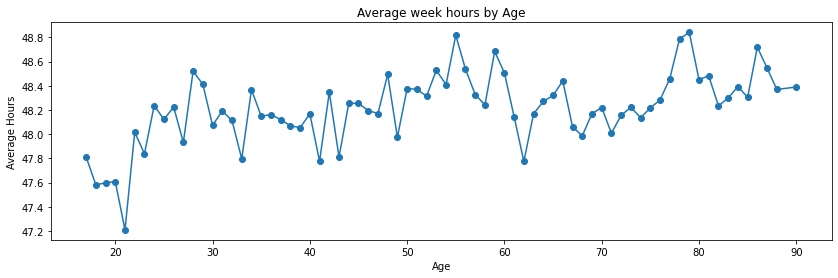

Insight 1: In this line plot we see Average work week hours by age. We do not see a big difference between average hours by age, average hours is between 47.2 and 48.8 hours per week


In [7]:
# Insight 1
plt_1 = spark.sql('SELECT age, avg(hours_per_week) as avg_hours_week FROM df group by 1 order by 1')
#convert to pandas prior to visualization
plt_1 = plt_1.toPandas()
# Plot 1
plt.figure(figsize=(14,4))
plt.plot('age', 'avg_hours_week', data=plt_1, linestyle='-', marker='o')
plt.title('Average week hours by Age')
plt.xlabel('Age')
plt.ylabel('Average Hours')
plt.show()
print('Insight 1: In this line plot we see Average work week hours by age. We do not see a big difference between average hours by age, average hours is between 47.2 and 48.8 hours per week')

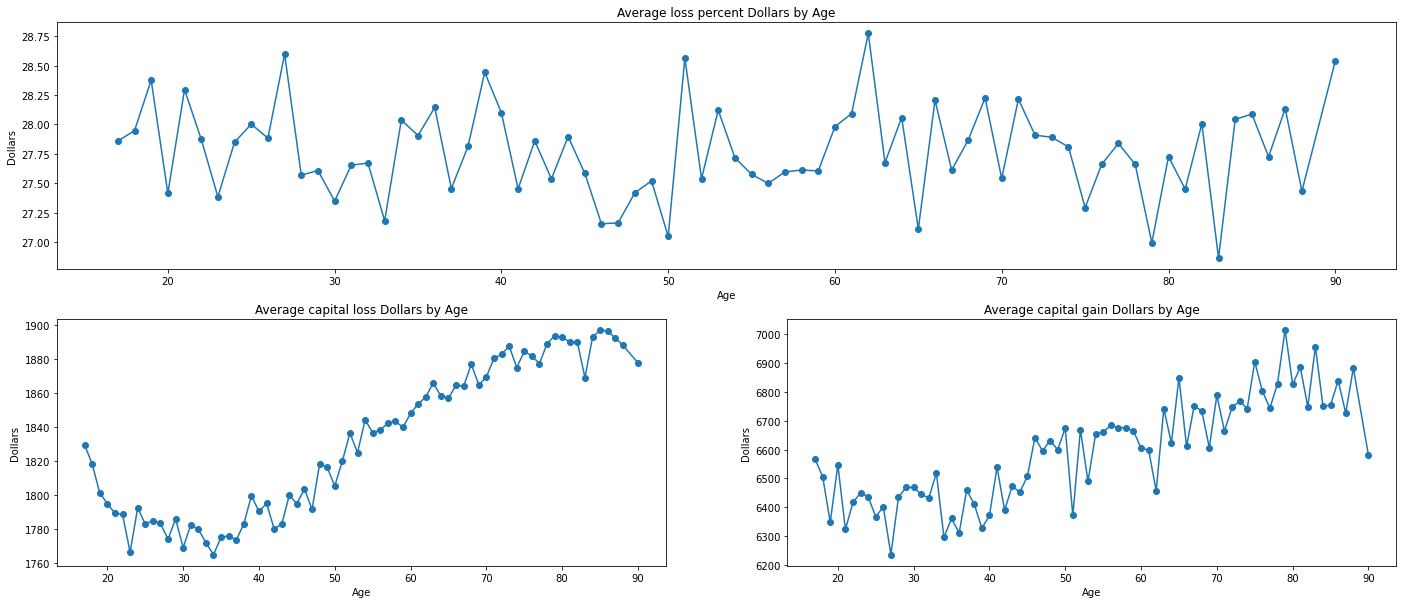

Insight 2: In this 3 plots we see Average capital loss percent, cpital gain, and capital loss Dollars by age. We don't see a big difference in percentages since it starts from 26.86% and ends with 28.77% . But 62,27, and 51 ages are have the highest percentages in average loss respectively.
For both average capital gain and loss we see those increase with age.


In [8]:
# Insight 2
plt_2 = spark.sql('SELECT age, avg(capital_gain) as avg_gain, avg(capital_loss) as avg_loss, avg(capital_loss)/avg(capital_gain)*100 as avg_loss_percent FROM df group by 1 order by 1')
#convert to pandas prior to visualization
plt_2 = plt_2.toPandas()
# Plot 2
plt.figure(figsize=(24,10))
# plt.subplot(1, 3, 1)
plt.subplot2grid((2, 2), (1, 1), colspan=1)
plt.plot('age', 'avg_gain', data=plt_2, linestyle='-', marker='o')
plt.title('Average capital gain Dollars by Age')
plt.xlabel('Age')
plt.ylabel('Dollars')
# plt.subplot(1, 3, 2)
plt.subplot2grid((2, 2), (1, 0), colspan=1)
plt.plot('age', 'avg_loss', data=plt_2, linestyle='-', marker='o')
plt.title('Average capital loss Dollars by Age')
plt.xlabel('Age')
plt.ylabel('Dollars')
# plt.subplot(1, 3, 3)
plt.subplot2grid((2, 2), (0, 0), colspan=2)
plt.plot('age', 'avg_loss_percent', data=plt_2, linestyle='-', marker='o')
plt.title('Average loss percent Dollars by Age')
plt.xlabel('Age')
plt.ylabel('Dollars')
plt.show()
print('Insight 2: In this 3 plots we see Average capital loss percent, cpital gain, and capital loss Dollars by age. We don\'t see a big difference in percentages since it starts from 26.86% and ends with 28.77% . But 62,27, and 51 ages are have the highest percentages in average loss respectively.\nFor both average capital gain and loss we see those increase with age.')

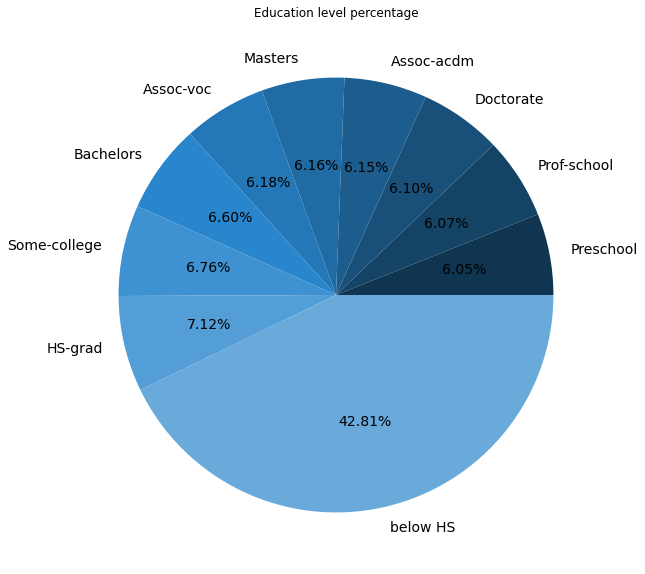

Insight 4: In this pie plot we count education. The education values are equal around 6% except for a slight height in the High School, Some-College,and Bachelors are around 7%.


In [9]:
# Insight 4
plt_4 = spark.sql('SELECT education FROM df')
#convert to pandas prior to visualization
plt_4 = plt_4.toPandas()
plt_4_c = plt_4['education'].value_counts(ascending=True)
# Plot 4
plt.figure(figsize=(10,10))
plt.title('Education level percentage')
colors = ['#103551','#144366','#18507a','#1c5d8e','#206ba3','#2478b7','#2986cc','#3e92d1','#539ed6','#69aadb','#7eb6e0','#94c2e5','#a9ceea','#bedaef','#d4e6f4','#e9f2f9']
plt.pie(plt_4_c.values,labels=plt_4_c.index, colors=colors,autopct='%.2f%%', textprops={'fontsize': 14})
plt.show()
print('Insight 4: In this pie plot we count education. The education values are equal around 6% except for a slight height in the High School, Some-College,and Bachelors are around 7%.')

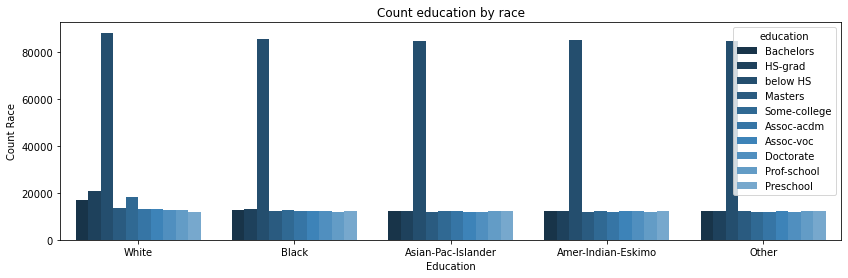

Insight 3: In this hue plot we count race by education. We do not see a big difference in education by race except in White race. The High School, Some College, and Bachelors are the highest number of education between white poeple respectively.


In [10]:
# Insight 3
plt_3 = spark.sql('SELECT race, education FROM df ')
#convert to pandas prior to visualization
plt_3 = plt_3.toPandas()
# Plot 3
plt.figure(figsize=(14,4))
colors = ['#103551','#144366','#18507a','#1c5d8e','#206ba3','#2478b7','#2986cc','#3e92d1','#539ed6','#69aadb','#7eb6e0','#94c2e5','#a9ceea','#bedaef','#d4e6f4','#e9f2f9']
sns.countplot(x='race',data=plt_3, hue='education', palette = colors)
plt.title('Count education by race')
plt.xlabel('Education')
plt.ylabel('Count Race')
plt.show()
print('Insight 3: In this hue plot we count race by education. We do not see a big difference in education by race except in White race. The High School, Some College, and Bachelors are the highest number of education between white poeple respectively.')

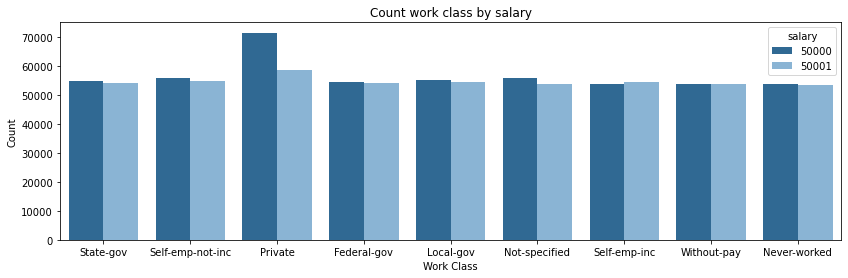

Insight 5: In this bar plot we count work class by salary. We do not see a big difference in work class count except in Private class more than 70k poeple have salary equal 50k or less.


In [11]:
# Insight 5
plt_5 = spark.sql('SELECT workclass, salary FROM df')
#convert to pandas prior to visualization
plt_5 = plt_5.toPandas()
# Plot 5
plt.figure(figsize=(14,4))
colors = ['#206ba3','#7eb6e0']
sns.countplot(x='workclass',data=plt_5, hue='salary', palette=colors)
plt.title('Count work class by salary')
plt.xlabel('Work Class')
plt.ylabel('Count')
plt.show()
print('Insight 5: In this bar plot we count work class by salary. We do not see a big difference in work class count except in Private class more than 70k poeple have salary equal 50k or less.')

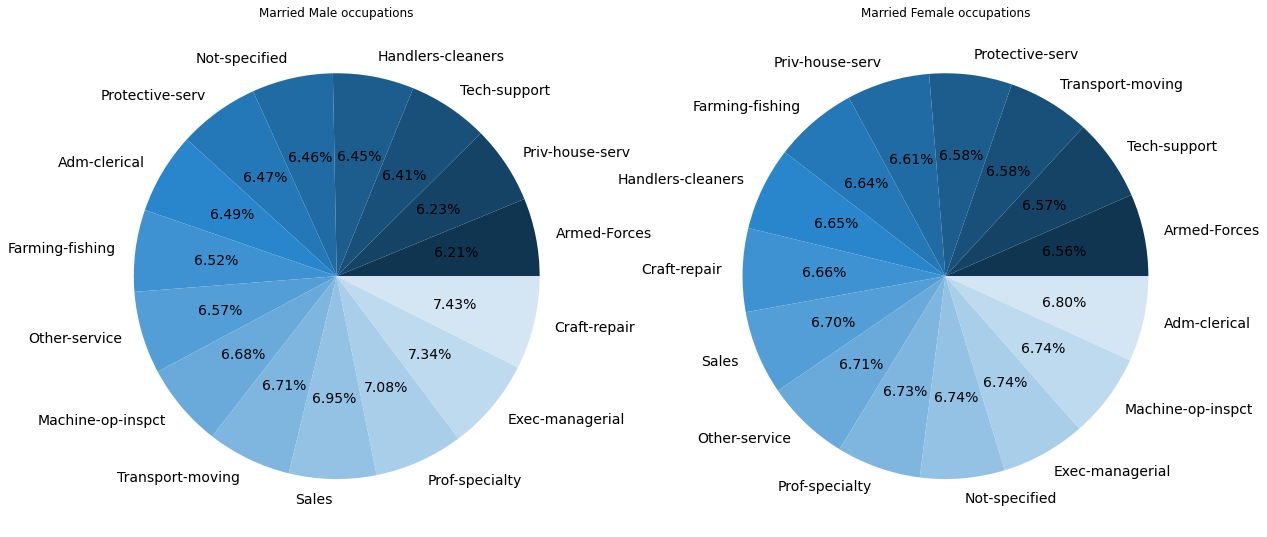

Insight 6: In these two pie plots we count occupation by married male and female. We do not see a big difference in occupation count in each gender. The occupation equally diverse in each gender approximately.


In [12]:
# Insight 5
plt_6_m = spark.sql('SELECT occupation FROM df where marital_status in ("Married-civ-spouse","Married-spouse-absent","Married-AF-spouse") and gender="Male"')
#convert to pandas prior to visualization
plt_6_m = plt_6_m.toPandas()
plt_6_cm = plt_6_m['occupation'].value_counts(ascending=True)

plt_6_f = spark.sql('SELECT occupation FROM df where marital_status in ("Married-civ-spouse","Married-spouse-absent","Married-AF-spouse") and gender="Female"')
#convert to pandas prior to visualization
plt_6_f = plt_6_f.toPandas()
plt_6_cf = plt_6_f['occupation'].value_counts(ascending=True)

# Plot 5
plt.figure(figsize=(20,20))
colors = ['#103551','#144366','#18507a','#1c5d8e','#206ba3','#2478b7','#2986cc','#3e92d1','#539ed6','#69aadb','#7eb6e0','#94c2e5','#a9ceea','#bedaef','#d4e6f4','#e9f2f9']
plt.subplot(1, 2, 1)
plt.pie(plt_6_cm.values, labels=plt_6_cm.index, autopct='%.2f%%',colors =colors , textprops={'fontsize': 14})
plt.title('Married Male occupations')
plt.subplot(1, 2, 2)
plt.pie(plt_6_cf.values, labels=plt_6_cf.index, autopct='%.2f%%', colors =colors,textprops={'fontsize': 14})
plt.title('Married Female occupations')
plt.show();
print('Insight 6: In these two pie plots we count occupation by married male and female. We do not see a big difference in occupation count in each gender. The occupation equally diverse in each gender approximately.')

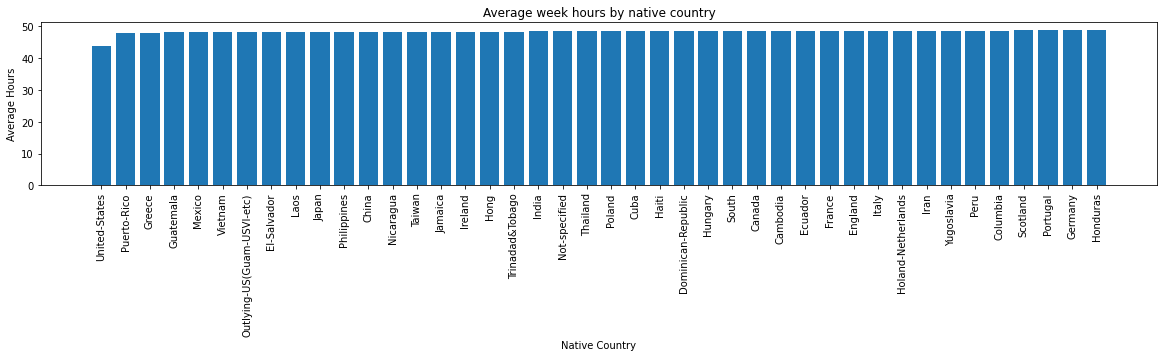

Insight 7: In this par plot we see Average work week hours by native country. We do not see a big difference between average hours by native country, minimum average hours was 43.98 for US and the maximum average was 48.83 hours for Honduras.


In [13]:
# Insight 7
plt_7 = spark.sql('SELECT native_country, avg(hours_per_week) as avg_hours_week FROM df group by 1 order by 2')
#convert to pandas prior to visualization
plt_7 = plt_7.toPandas()
# Plot 7
plt.figure(figsize=(20,3))
plt.bar(plt_7['native_country'], plt_7['avg_hours_week'])
plt.title('Average week hours by native country')
plt.xlabel('Native Country')
plt.ylabel('Average Hours')
plt.xticks(rotation=90)
plt.show()
print('Insight 7: In this par plot we see Average work week hours by native country. We do not see a big difference between average hours by native country, minimum average hours was 43.98 for US and the maximum average was 48.83 hours for Honduras.')

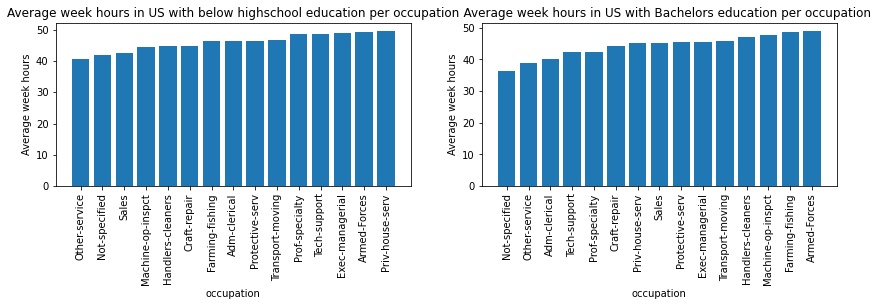

Insight 8: In this two bar plots we see Average work week hours by occupation in US between below HS and Bachelors educations. We see both have their highest average week hours in Armed_Forces and also we see in Bachelors  they have average week hours in Handlers-cleaners higher than who dont have high school degree.


In [19]:
# Insight 8
plt_8_m = spark.sql('SELECT occupation, avg(hours_per_week) as avg_hours_week FROM df  where education in ("below HS") and native_country="United-States" group by 1 order by 2')
#convert to pandas prior to visualization
plt_8_m = plt_8_m.toPandas()

plt_8_f = spark.sql('SELECT occupation, avg(hours_per_week) as avg_hours_week FROM df where education in ("Bachelors") and native_country="United-States" group by 1 order by 2')
#convert to pandas prior to visualization
plt_8_f = plt_8_f.toPandas()
# Plot 8
plt.figure(figsize=(14,3))
plt.subplot(1, 2, 1)
plt.bar(plt_8_m['occupation'], plt_8_m['avg_hours_week'])
plt.xticks(rotation=90)
plt.title('Average week hours in US with below highschool education per occupation')
plt.xlabel('occupation')
plt.ylabel('Average week hours')
plt.subplot(1, 2, 2)
plt.bar(plt_8_f['occupation'], plt_8_f['avg_hours_week'])
plt.xticks(rotation=90)
plt.title('    Average week hours in US with Bachelors education per occupation')
plt.xlabel('occupation')
plt.ylabel('Average week hours')
plt.show()
print('Insight 8: In this two bar plots we see Average work week hours by occupation in US between below HS and Bachelors educations. We see both have their highest average week hours in Armed_Forces and also we see in Bachelors  they have average week hours in Handlers-cleaners higher than who dont have high school degree.')

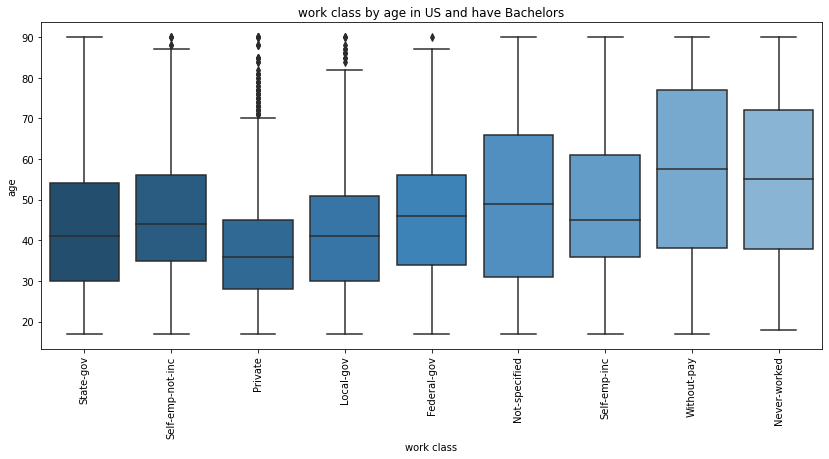

Insight 9: In this box plot we see work class by age in US for Bachelors. We see 75% of Private work class are younger then 50.


In [15]:
# Insight 9
plt_9 = spark.sql('SELECT workclass, age FROM df where native_country="United-States" and education in ("Bachelors")')
#convert to pandas prior to visualization
plt_9 = plt_9.toPandas()
# Plot 9
plt.figure(figsize=(14,6))
colors = ['#18507a','#1c5d8e','#206ba3','#2478b7','#2986cc','#3e92d1','#539ed6','#69aadb','#7eb6e0','#94c2e5','#a9ceea','#bedaef','#d4e6f4','#e9f2f9']

sns.boxplot( x=plt_9["workclass"], y=plt_9["age"], palette=colors)
plt.title('work class by age in US and have Bachelors')
plt.xlabel('work class')
plt.ylabel('age')
plt.xticks(rotation=90)
plt.show()
print('Insight 9: In this box plot we see work class by age in US for Bachelors. We see 75% of Private work class are younger then 50.')

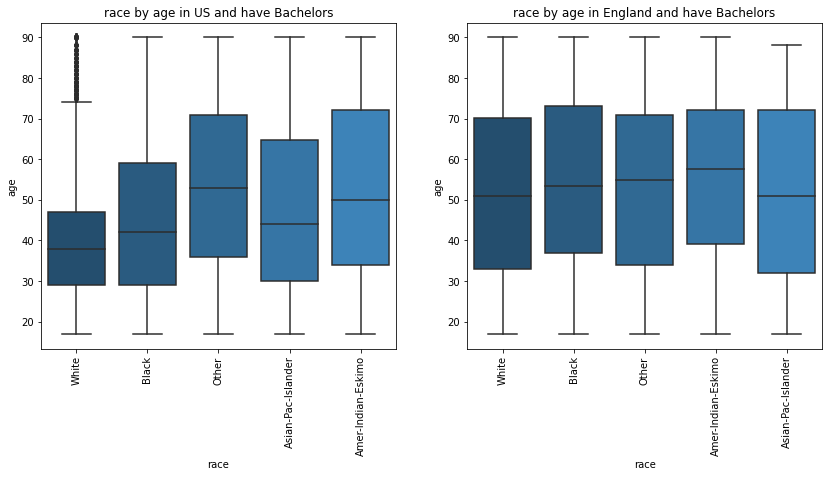

Insight 10: In this two box plots we see race by age in US and England who have Bachelors. We see the 75% who have Bachelors in US's white, black, and Asian-Pac-Islander are younger than hwo in England.


In [16]:
# Insight 10
plt_9_m = spark.sql('SELECT race, age FROM df where native_country="United-States" and education in ("Bachelors")')
#convert to pandas prior to visualization
plt_9_m = plt_9_m.toPandas()

plt_9_f = spark.sql('SELECT race, age FROM df where native_country="England" and education in ("Bachelors")')
#convert to pandas prior to visualization
plt_9_f = plt_9_f.toPandas()
# Plot 10
plt.figure(figsize=(14,6))
colors = ['#18507a','#1c5d8e','#206ba3','#2478b7','#2986cc','#3e92d1','#539ed6','#69aadb','#7eb6e0','#94c2e5','#a9ceea','#bedaef','#d4e6f4','#e9f2f9']

plt.subplot(1, 2, 1)
sns.boxplot( x=plt_9_m["race"], y=plt_9_m["age"] , palette=colors)
plt.title('race by age in US and have Bachelors')
plt.xlabel('race')
plt.ylabel('age')
plt.xticks(rotation=90)
plt.subplot(1, 2, 2)
sns.boxplot( x=plt_9_f["race"], y=plt_9_f["age"] , palette=colors)
plt.title('race by age in England and have Bachelors')
plt.xlabel('race')
plt.ylabel('age')
plt.xticks(rotation=90)
plt.show()
print('Insight 10: In this two box plots we see race by age in US and England who have Bachelors. We see the 75% who have Bachelors in US\'s white, black, and Asian-Pac-Islander are younger than hwo in England.')

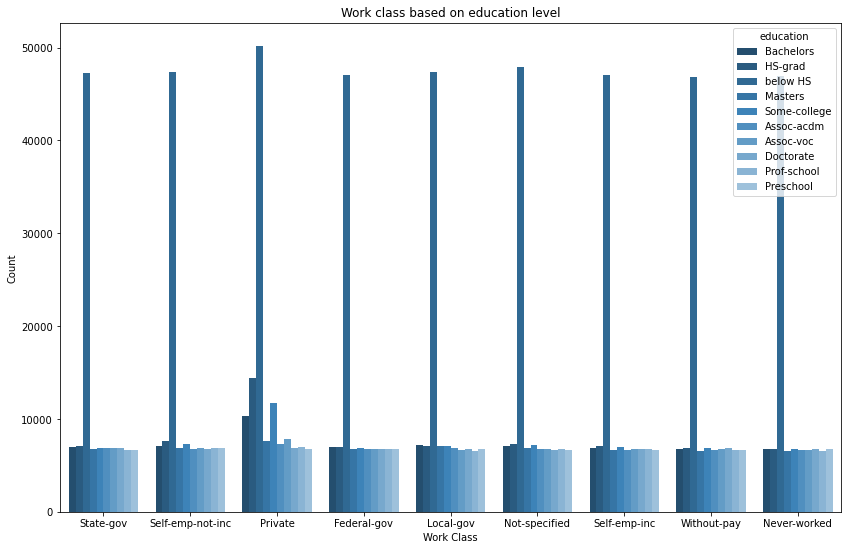

Employing all education levels is almost constant in all sectors. However, There is signigicant demand in the private sector for Bachelor, master and high-school graduates 


In [17]:
plt_11 = spark.sql('SELECT workclass, education FROM df')
#convert to pandas prior to visualization
plt_11 = plt_11.toPandas()
# Plot 11
plt.figure(figsize=(14,9))
colors = ['#18507a','#1c5d8e','#206ba3','#2478b7','#2986cc','#3e92d1','#539ed6','#69aadb','#7eb6e0','#94c2e5','#a9ceea','#bedaef','#d4e6f4','#e9f2f9']
sns.countplot(x='workclass',data=plt_11, hue='education', palette=colors)
plt.title('Work class based on education level')
plt.xlabel('Work Class')
plt.ylabel('Count')
plt.show()
print('Employing all education levels is almost constant in all sectors. However, There is signigicant demand in the private sector for Bachelor, master and high-school graduates ')